In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

from IPython import display
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import math

In [2]:

class memristor():
                                                                                   #Kon= -70*10**(-6)
    def __init__(self, 
                 w_current,
                 Von = 0.6,
                 Voff = -0.6,
                 Ron=500,
                 Roff=25000,
                 L=6*10**(-7),
                 Kon=-0.396*10**(-7), 
                 Koff=1.054*10**(-8),
                 Aon=2.357,
                 Aoff=2.022,
                 a_on = 0.368*10**(-7),
                 a_off = 0.12*10**(-9),
                 x_c = 40,
                 x_c_on = 0.038*10**(-6)):
        
        self.w_current = w_current
        self.V_on = Von
        self.V_off = Voff
        self.R_on = Ron
        self.R_off = Roff
        self.x_off = L
        self.x_on = 0
        self.x = self.x_current(self.w_current)
        self.K_on=Kon
        self.K_off=Koff
        self.Alpha_on=Aon
        self.Alpha_off=Aoff
        self.R = np.exp(np.log(self.R_off/self.R_on) * (self.x - self.x_on)/(self.x_off - self.x_on)) * self.R_on
        self.G_norm = 1/Ron - 1/Roff
        self.a_on = a_on
        self.a_off = a_off
        self.x_c = x_c
        self.x_c_on = x_c_on
        
    def Res(self, InVolt, dt):
        
            if (InVolt <= self.V_off):
    
                dxdt = self.K_off*((InVolt/self.V_off-1)**self.Alpha_off)
    
            if (InVolt >= self.V_on):
    
                dxdt = self.K_on*((InVolt/self.V_on-1)**self.Alpha_on)
    
            if ((self.V_on > InVolt) and (InVolt > self.V_off)):
  
                dxdt=0

            if (InVolt < 0):
           
                self.x = self.x + dt*dxdt*np.exp(-np.exp((self.x - self.a_off)/self.x_c))
                #self.x = self.x + dt* dxdt
        
            if (InVolt >= 0):
       
                self.x = self.x + dt*dxdt*np.exp(-np.exp((self.a_on - self.x)/self.x_c_on))
                #self.x = self.x + dt* dxdt
            
            if (self.x>=self.x_off):

                dxdt=0
                self.x = self.x_off
    
            if (self.x<=self.x_on):
    
                dxdt = 0
                self.x = self.x_on
    
            #return self.R_on + (self.x - self.x_on)*(self.R_off - self.R_on)/(self.x_off - self.x_on)
            self.R = np.exp(np.log(self.R_off/self.R_on) * (self.x - self.x_on)/(self.x_off - self.x_on)) * self.R_on
    
    def update(self, R: float):
    
        self.R = R
        
    def x_current (self, w_current: float):
       
        R = 1/(1/self.R_off + w_current*(1/self.R_on - 1/self.R_off))
        
        return self.x_on + (self.x_off - self.x_on)*(np.log(R/self.R_on))/(np.log(self.R_off/self.R_on))

    def reset(self):  
         
        self.x = self.x_current(self.w_current)
        self.R = np.exp(np.log(self.R_off/self.R_on) * (self.x - self.x_on)/(self.x_off - self.x_on)) * self.R_on
    

In [3]:
dt = 1

#memr = memristor()

impulse_length = 40.0  #длительность импулсьа
impulse_amplitude = 0.42
impulse_amplitude_2 = 0.42

k = 0.9


In [4]:
def impulse_curve_2(t, dt, impulse_length, impulse_amplitude, impulse_amplitude_2): #производная импульса, inverted true
        
        impulse_value_2 = impulse_amplitude/(impulse_length*k -dt) #производная в точках, не находящихся в середине импульса
        
        impulse_value_1 = impulse_amplitude_2/(impulse_length*(1-k))
        
        impulse_bias =  ((impulse_amplitude + impulse_amplitude_2) *(t > (impulse_length * (1-k)+dt/2)) *(t <= (impulse_length * (1-k)+1.5*dt)))/dt
                                               
        impulse = (-impulse_value_1) * (t > 0) * (t <= (impulse_length * (1-k)+dt/2)) + (-impulse_value_2)  * (t > (impulse_length * (1-k)+1.5*dt)) + impulse_bias
        
        #impulse = (-impulse_value)/(1-k)  * (t > impulse_length * k) + impulse_bias

        return impulse

In [5]:
def impulse_curve_2_integrated(k, dt, impulse_length, impulse_amplitude, impulse_amplitude_2): # сам импульс, принимает не время, а номер шага по времени и dt, это чтобы при операциях с float меньше терять
    #информацию
    
    current = 0
    
    for i in range (k+1):
    
        current +=  dt * impulse_curve_2(i*dt, dt, impulse_length, impulse_amplitude, impulse_amplitude_2)
        
        #print(i*dt,'\n')
        if (i * dt >= impulse_length):
            current = 0
        
    return current
    

Text(0, 0.5, 'U, V')

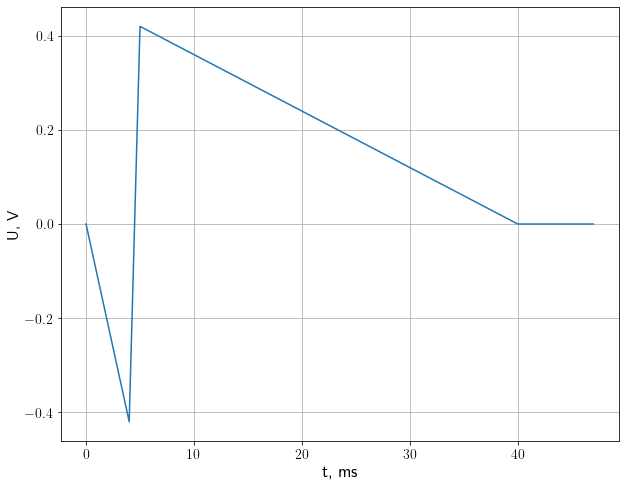

In [6]:
#строим импульс
matplotlib.rcParams['text.usetex'] = True

ar = []

for i in range(int(impulse_length/dt) + int(impulse_length/5)):
    #if i:
    #    ar.append(impulse_curve_2(i * dt, dt) * dt + ar[i-1])
    #else:
    #    ar.append(impulse_curve_2(i * dt, dt) * dt)
    
    ar.append(impulse_curve_2_integrated(i , dt, impulse_length, impulse_amplitude, impulse_amplitude_2))
    #print(i*dt,'\n')
    
      
#print(ar)    
fig_w_0 = plt.figure(figsize=(10,8))
gr_1 = fig_w_0.add_subplot(1,1,1)
gr_1.plot(np.arange(int(impulse_length/dt) + int(impulse_length/5)), ar)
gr_1.grid()
#plt.show()
#ar.clear()

gr_1.tick_params(axis='both', which='major', labelsize=14)
gr_1.set_xlabel('t, ms',fontsize = 18)
gr_1.set_ylabel("U, V",fontsize = 16)

In [7]:
import torch

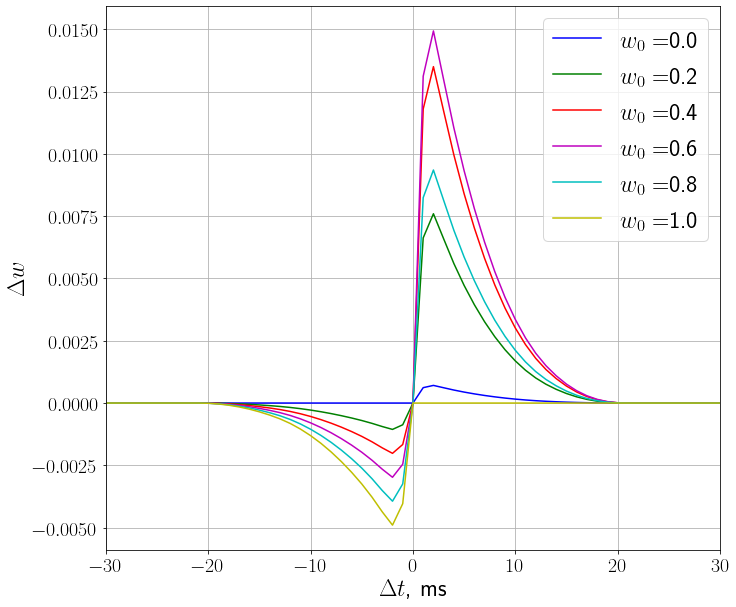

In [8]:
#Промеряем STDP
delta_w = []
colors_P = ['b','g','r','m','c','y','k']
plt.figure(figsize=(11,10))

pi = 3.1415/impulse_length


for num in range (0,6):
    
    w_current = num/5
    
    memr = memristor(w_current)
    
    
    for count in range(int(-60/dt), int(60/dt)):
    
        delta_t = count * dt
    
        R_c = memr.R
    
        for t_s in range( 0 , int((impulse_length + abs(delta_t))/dt)):
        
            t = t_s * dt

            if (delta_t > 0):
                memr.Res(impulse_curve_2_integrated(t_s, dt, impulse_length, impulse_amplitude, impulse_amplitude_2)*(t<=impulse_length) - impulse_curve_2_integrated(int(( t - delta_t)/dt), dt,impulse_length, impulse_amplitude, impulse_amplitude_2)*(t>=abs(delta_t)), dt) 

            else:
                memr.Res(impulse_curve_2_integrated(int(( t - abs(delta_t))/dt), dt, impulse_length, impulse_amplitude, impulse_amplitude_2)*(t>=abs(delta_t)) - impulse_curve_2_integrated(t_s, dt,impulse_length, impulse_amplitude, impulse_amplitude_2)*(t<=impulse_length), dt)
            
        delta_w_current = (1/memr.R - 1/R_c)/memr.G_norm

        delta_w.append(delta_w_current)  
        memr.reset()
    
    plt.plot([delta_t for delta_t in range(int(-60/dt), int(60/dt))], delta_w, color=colors_P[num],label= ("$w_{0} =$"+str(w_current)) )
    #plt.plot(delta_t, delta_w_STDP1, label='с+', color='r')

    #delta_w.append('\n')
    #fl.writelines(delta_w)
    delta_w.clear()
plt.ylabel('$\Delta w$',fontsize = 24)
plt.xlabel('$\Delta t$, ms',fontsize = 24)
plt.tick_params(axis='both', which='major', labelsize=20)
#plt.legend(loc='best')
plt.xlim(-30, 30)
plt.grid()
plt.legend(loc="best",fontsize = 24)
plt.show()    